In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("\nПример сырых данных:")
sample_cols = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt', 'SalePrice']
print(train[sample_cols].head().to_string())




Пример сырых данных:
   GrLivArea  TotalBsmtSF  OverallQual  YearBuilt  SalePrice
0       1710          856            7       2003     208500
1       1262         1262            6       1976     181500
2       1786          920            7       2001     223500
3       1717          756            7       1915     140000
4       2198         1145            8       2000     250000


In [ ]:
y = np.log1p(train['SalePrice']) 
X = train.drop(['Id', 'SalePrice'], axis=1)
test_ids = test['Id']
test = test.drop('Id', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n Пример нормализованных числовых данных:")
numeric_cols = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
X_train_num = numeric_transformer.fit_transform(X_train[numeric_cols])
print(pd.DataFrame(X_train_num[:5], columns=numeric_cols).to_string())



 Пример нормализованных числовых данных:
   GrLivArea  TotalBsmtSF  OverallQual  YearBuilt
0  -0.407093     0.572612    -0.820445  -0.455469
1   0.083170    -0.596547    -0.088934   0.718609
2  -1.395250    -0.603357    -0.820445  -1.988293
3   0.458975    -0.750921    -0.820445  -1.107734
4   0.312087    -0.081209    -0.820445  -1.531707


In [ ]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ])

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
model.fit(X_train_processed, y_train)

GradientBoostingRegressor(learning_rate=0.05, n_estimators=1000,
                          random_state=42, subsample=0.8)

In [ ]:
y_train_pred = model.predict(X_train_processed)
y_val_pred = model.predict(X_val_processed)

y_train_exp = np.expm1(y_train)
y_train_pred_exp = np.expm1(y_train_pred)
y_val_exp = np.expm1(y_val)
y_val_pred_exp = np.expm1(y_val_pred)

train_mse = mean_squared_error(y_train_exp, y_train_pred_exp)
val_mse = mean_squared_error(y_val_exp, y_val_pred_exp)
train_r2 = r2_score(y_train_exp, y_train_pred_exp)
val_r2 = r2_score(y_val_exp, y_val_pred_exp)
print(f"Обучающая выборка: MSE = {train_mse:.2f}, R² = {train_r2:.4f}")
print(f"Валидационная выборка: MSE = {val_mse:.2f}, R² = {val_r2:.4f}")


Обучающая выборка: MSE = 28801672.98, R² = 0.9952
Валидационная выборка: MSE = 787621779.41, R² = 0.8973


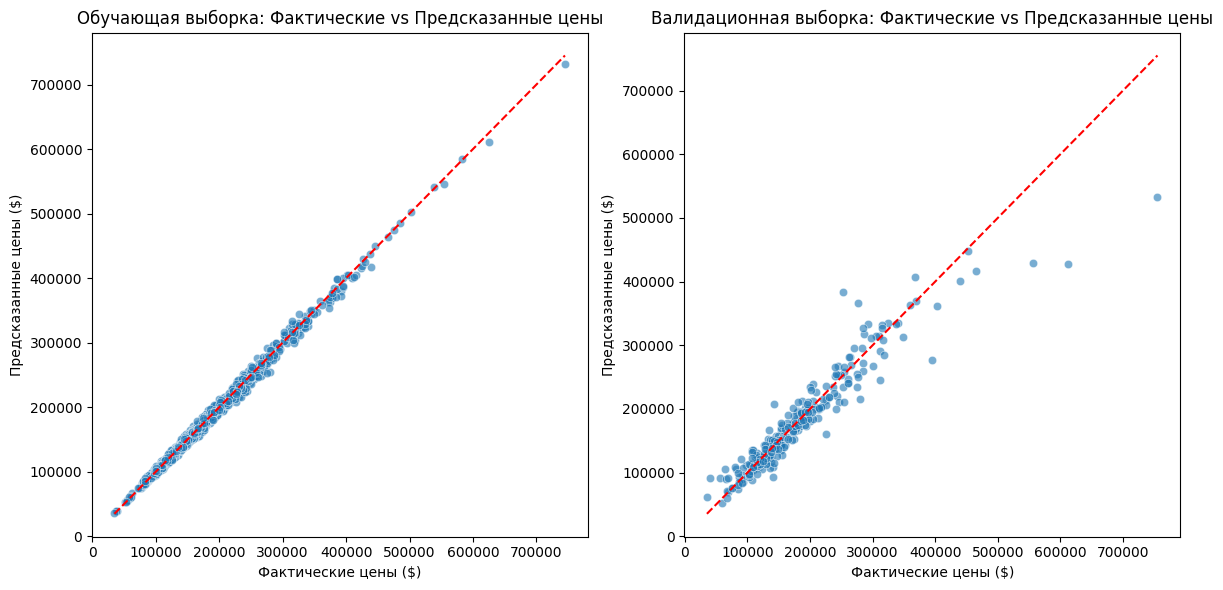

In [57]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_exp, y=y_train_pred_exp, alpha=0.6)
plt.plot([min(y_train_exp), max(y_train_exp)], [min(y_train_exp), max(y_train_exp)], '--r')
plt.title('Обучающая выборка: Фактические vs Предсказанные цены')
plt.xlabel('Фактические цены ($)')
plt.ylabel('Предсказанные цены ($)')

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val_exp, y=y_val_pred_exp, alpha=0.6)
plt.plot([min(y_val_exp), max(y_val_exp)], [min(y_val_exp), max(y_val_exp)], '--r')
plt.title('Валидационная выборка: Фактические vs Предсказанные цены')
plt.xlabel('Фактические цены ($)')
plt.ylabel('Предсказанные цены ($)')
plt.tight_layout()
plt.show()

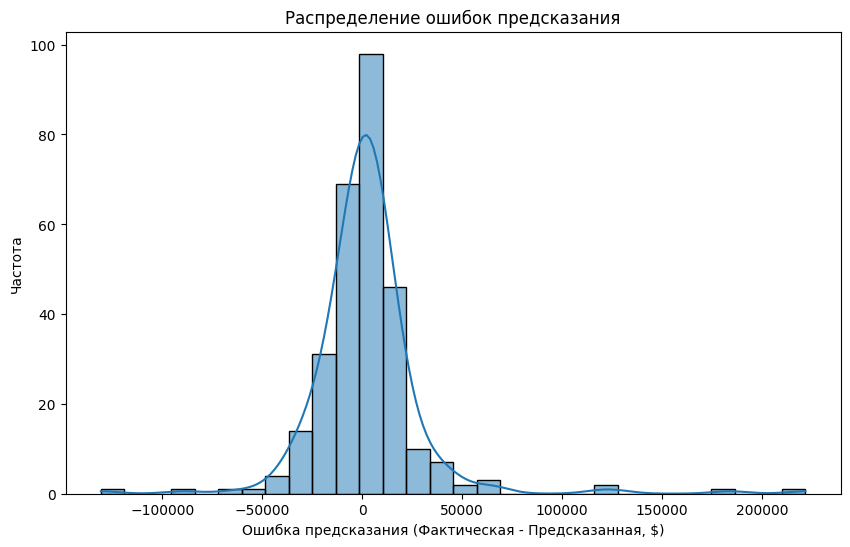

In [48]:
errors = y_val_exp - y_val_pred_exp
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка предсказания (Фактическая - Предсказанная, $)')
plt.ylabel('Частота')
plt.show()


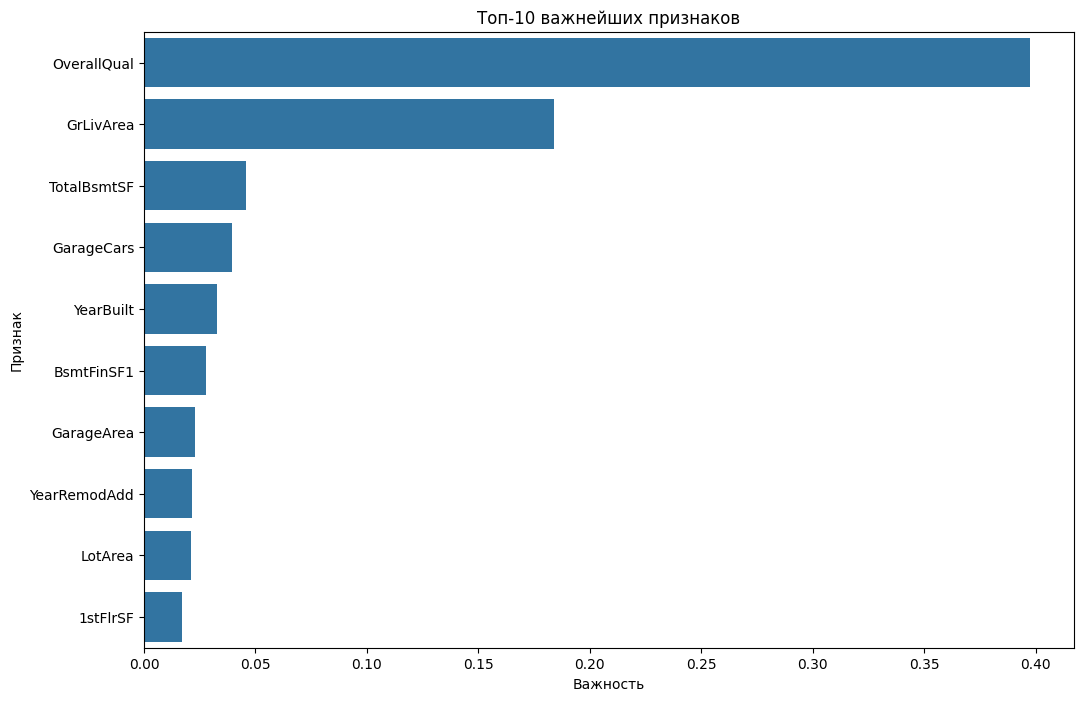


Топ-10 важных признаков:
     Признак  Важность
 OverallQual  0.397383
   GrLivArea  0.184024
 TotalBsmtSF  0.045908
  GarageCars  0.039594
   YearBuilt  0.032719
  BsmtFinSF1  0.027680
  GarageArea  0.022737
YearRemodAdd  0.021324
     LotArea  0.021037
    1stFlrSF  0.016837


In [49]:
feature_importance = pd.DataFrame({
    'Признак': numerical_features,
    'Важность': model.feature_importances_[:len(numerical_features)]
}).sort_values('Важность', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Важность', y='Признак', data=feature_importance.head(10))
plt.title('Топ-10 важнейших признаков')
plt.show()

print("\nТоп-10 важных признаков:")
print(feature_importance.head(10).to_string(index=False))

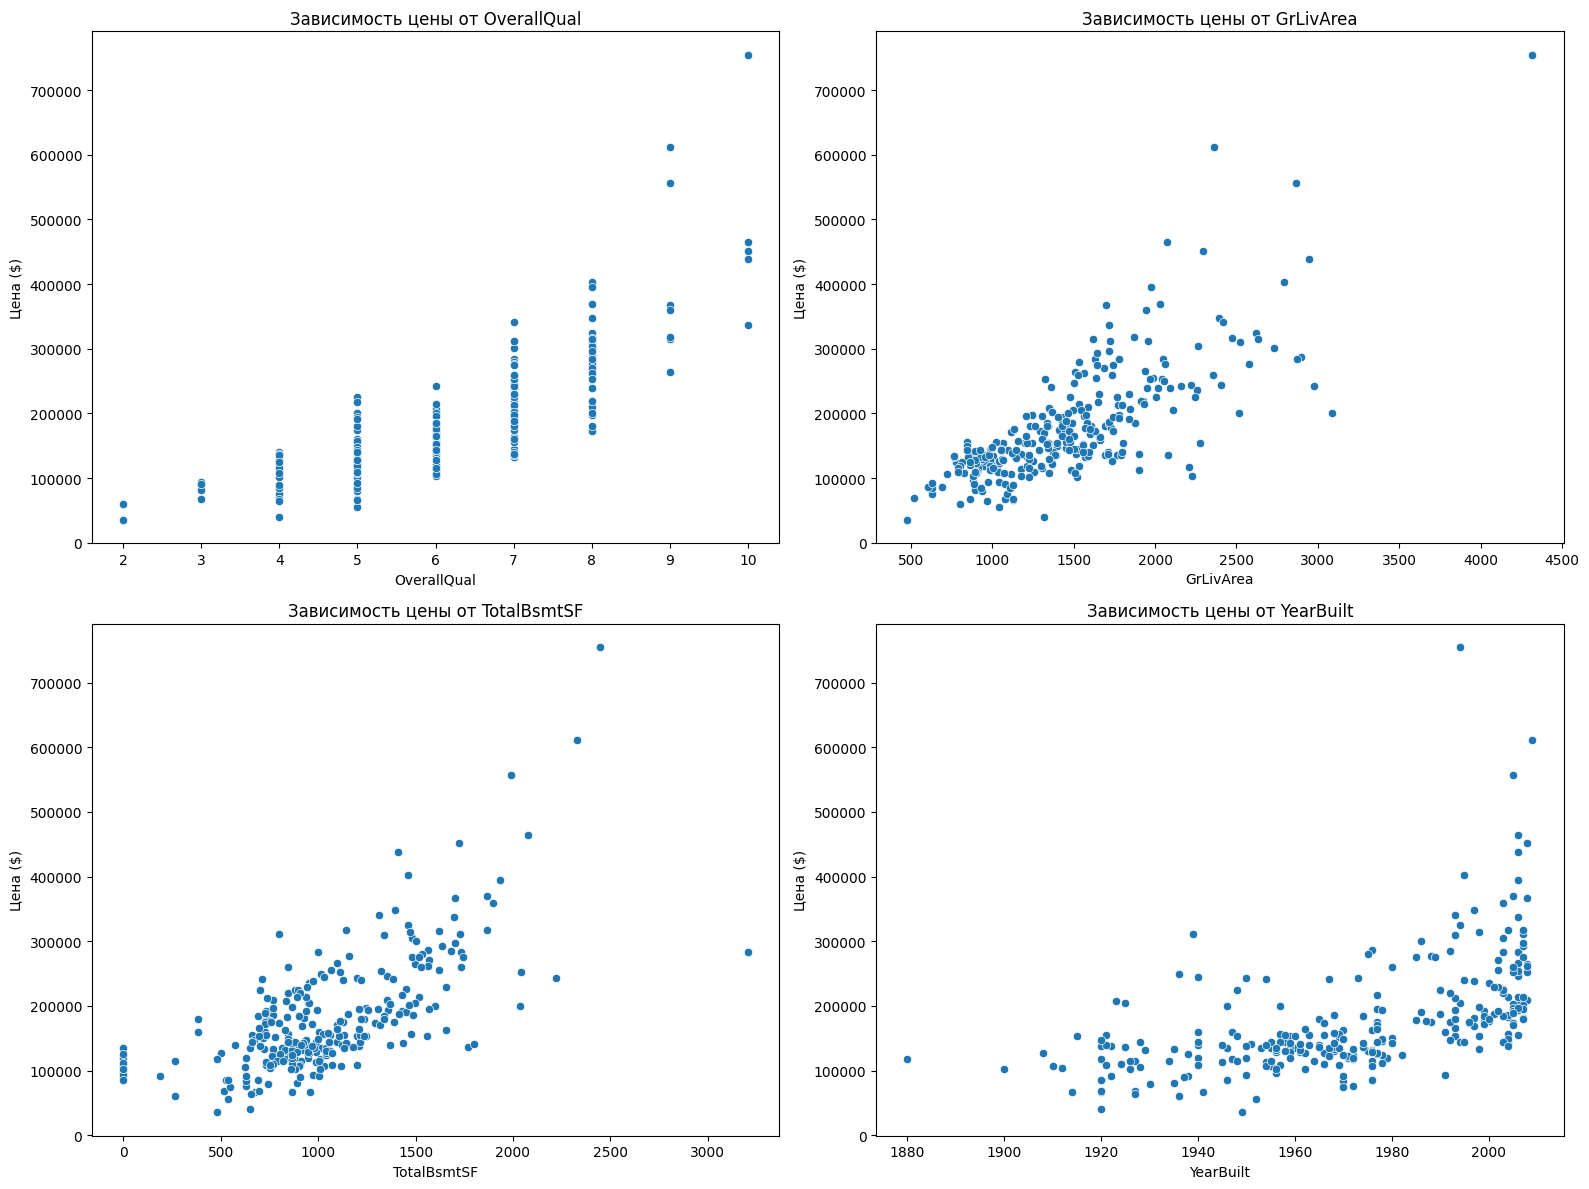

In [50]:
key_features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']
plt.figure(figsize=(16, 12))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=X_val[feature], y=y_val_exp)
    plt.title(f'Зависимость цены от {feature}')
    plt.xlabel(feature)
    plt.ylabel('Цена ($)')
plt.tight_layout()
plt.show()

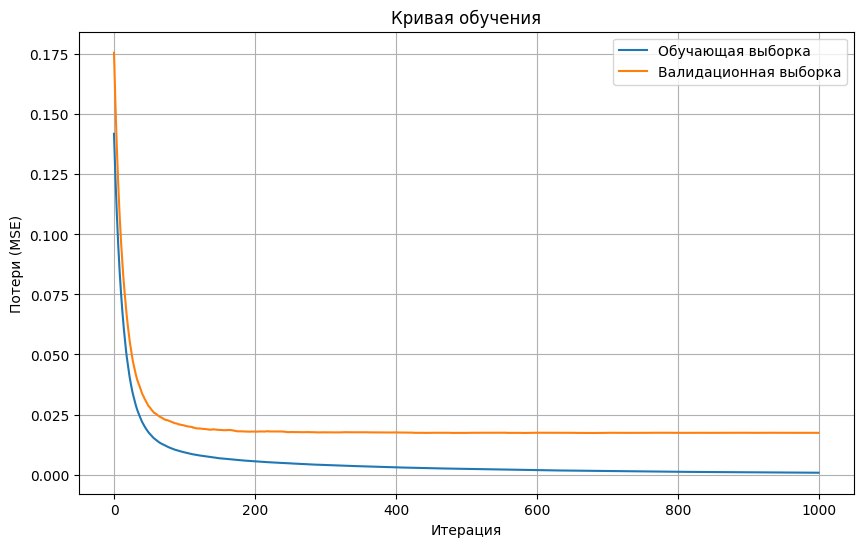

In [51]:
train_loss = []
val_loss = []

for y_pred in model.staged_predict(X_train_processed):
    train_loss.append(mean_squared_error(y_train, y_pred))

for y_pred in model.staged_predict(X_val_processed):
    val_loss.append(mean_squared_error(y_val, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Обучающая выборка')
plt.plot(val_loss, label='Валидационная выборка')
plt.xlabel('Итерация')
plt.ylabel('Потери (MSE)')
plt.title('Кривая обучения')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
X_test_processed = preprocessor.transform(test)
test_preds = np.expm1(model.predict(X_test_processed))
output = pd.DataFrame({'Id': test_ids, 'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)